# Signal2Signal with RNN

Import the required packages :

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In this notebook we train a Recurrent Neural Network to predict a signal to signal correspondance. More precisely, we want to reproduce the following sequence:

$$(f_1(t_i),f_2(t_i),f_3(t_i))\to(f_4(t_i) = f_1(t_i)-f_2(t_i)-f_3(t_i))$$

where $f_i$ are given functions.

The functions are given by:

In [2]:
def f1(t):
   "f1 function"
   ret = torch.sin(t)
   return ret
def f2(t):
   "f2 function"
   ret = torch.cos(t)
   return ret
def f3(t):
   "f3 function"
   ret = t
   return ret
def f4(t):
   "f4 function"
   ret = f1(t) - f2(t) - f3(t) 
   return ret

They look like:

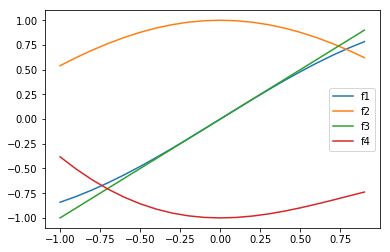

In [3]:
dt = 0.1
t = torch.arange(-1.0, 1.0, dt)
fig, ax = plt.subplots()
ax.plot(t.numpy(),f1(t).numpy(),"-", label="f1")
ax.plot(t.numpy(),f2(t).numpy(), "-", label="f2")
ax.plot(t.numpy(),f3(t).numpy(), "-", label="f3")
ax.plot(t.numpy(),f4(t).numpy(), "-", label="f4")
ax.legend();

## Pre-training

### Construct Data

We will cut the data in sequences of size seqlen data points. The input and target sequences are:

$$\left(
\begin{array}{cccc}
 f_1(t_{i}) & f_2(t_{i}) & f_3(t_{i})\\
 \vdots  & \vdots  & \vdots  \\
 f_1(t_{i+seqlen}) & f_2(t_{i+seqlen}) & f_3(t_{i+seqlen})
\end{array}
\right)
\to
\left(
\begin{array}{cccc}
f_4(t_{i}) \\
\vdots  \\
f_4(t_{i+seqlen})
\end{array}
\right)
$$

We create the Dataset object to manage the data. The method ``__getitem__`` returns a training example of the form:

$$\left(
\begin{array}{cccc}
 x_1^1 & x_1^2 & \ldots & x_1^{inputSize_x} \\
 \vdots  & \vdots  & \ldots  & \vdots  \\
 x_{seqlen}^1 & x_{seqlen}^2 & \ldots & x_{seqlen}^{inputSize_x} \\
\end{array}
\right)
\to
\left(
\begin{array}{cccc}
 y_1^1 & y_1^2 & \ldots & y_1^{inputSize_y} \\
 \vdots  & \vdots  & \ldots  & \vdots  \\
 y_{seqlen}^1 & y_{seqlen}^2 & \ldots & y_{seqlen}^{inputSize_y} \\
\end{array}
\right)
$$

In [4]:
class Sig2SigDataset(Dataset):
    """ Sig2Sig dataset."""
    
    def __init__(self, h_size, seq_len):
        
        # Generate the data
        tt = torch.arange(-1.0, 1.0, h_size)  
        lentt = tt.shape[0]
        
        # Check if h_size and seq_len are compatible
        if lentt - seq_len < 0:
            raise TypeError(f'h_size = {h_size} is too large for the seq_len = {seq_len}')     
        
        T1 = f1(tt).view([1,lentt]).t()
        T2 = f2(tt).view([1,lentt]).t()
        T3 = f3(tt).view([1,lentt]).t()
        dataX = torch.cat((T1, T2, T3), 1)    
        T4 = f4(tt).view([1,lentt]).t()
        dataY = T4 
        
        self.X = torch.zeros(lentt - seq_len, seq_len, 3)
        self.Y = torch.zeros(lentt - seq_len, seq_len, 1)
        
        self.len = self.X.shape[0]
        
        for i in range(self.len):
            self.X[i,:,:] = dataX[i:i + seq_len,:]
            self.Y[i,:,:] = dataY[i:i + seq_len,:]
                
    def __getitem__(self, index):
        return self.X[index,:,:], self.Y[index,:,:]

    def __len__(self):
        return self.len

### Design the Model

#### Using `torch.nn.RNN` or `torch.nn.LSTM`

We creeate a RNN with a readout layer:

In [5]:
class RNNModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, rnn_type = 'RNN'):
        super().__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        if rnn_type == 'RNN':
            self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first = True, nonlinearity = 'tanh')
        elif rnn_type == 'LSTM':    
            self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first = True)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden state with zeros by default         
        # One time step
        out, hn = self.rnn(x)
        out = self.fc(out) 
        return out

#### Using `torch.nn.RNNCell` or `torch.nn.LSTMCell`

We creeate a RNN with a cell layer:

In [6]:
class RNNModelWithCell(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, rnn_type = 'RNN'):
        super().__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Cell type
        self.rnn_type = rnn_type
        
        # RNN
        if self.rnn_type == 'RNN':
            self.rnn = nn.RNNCell(input_dim, hidden_dim, nonlinearity = 'tanh')
        elif self.rnn_type == 'LSTM':    
            self.rnn = nn.LSTMCell(input_dim, hidden_dim)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):    
        output = []
        # Initialize hidden state with zeros
        # hn.shape must be torch.Size([len_seq, hidden_dim])
        hn = torch.zeros(x.size(1), self.hidden_dim)
        if self.rnn_type == 'LSTM':
            cx = torch.zeros(x.size(1), self.hidden_dim)
        for i in range(x.size(0)):
            # One time step
            if self.rnn_type == 'RNN':
                hn = self.rnn(x[i], hn)
            elif self.rnn_type == 'LSTM':    
                hn, cx = self.rnn(x[i], (hn, cx))
            out = self.fc(hn)
            output.append(out)
        return torch.stack(output)

#### Initialization Algorithm

We define a initialization weight function:

In [18]:
# Initialitation
def init_weights(self):
    for idx, m in enumerate(self.modules()):         
        if idx > 0:
            print('{} -> {}'.format(idx,m))    
            if type(m) in [nn.RNN, nn.GRU, nn.LSTM, nn.RNNCell, nn.GRUCell, nn.LSTMCell]:
                for name, param in m.named_parameters():
                    print(f'Initialization of {name}', end="", flush=True)
                    if 'weight_ih' in name:   
                        torch.nn.init.xavier_uniform_(param.data)
                        print('...done')
                    elif 'weight_hh' in name:
                        torch.nn.init.orthogonal_(param.data)
                        print('...done')
                    elif 'bias' in name:
                        param.data.fill_(0)
                        print('...done')
            if type(m) in [nn.Linear]:
                for name, param in m.named_parameters():
                    print(f'Initialization of {name}', end="", flush=True)
                    if 'weight' in name:   
                        torch.nn.init.xavier_uniform_(param.data)
                        print('...done')
                    elif 'bias' in name:
                        param.data.fill_(0)
                        print('...done')           

## Training

Setup the training process: Model + Loss + Optimizer

In [49]:
# Data parameters
h_size = 0.001
seq_len = 100

# Global parameters
input_dim = 3      # input dimension
hidden_dim = 100   # hidden layer dimension
layer_dim = 1      # number of hidden layers
output_dim = 1     # output dimension
rnn_type = 'RNN'   # type of cell
cell_model = True  # Wether we use nn.RNN or nn.RNNCell

# Dataset
dataset = Sig2SigDataset(h_size, seq_len)
print('Length of dataset: {}\n'.format(dataset.__len__()))
# DataLoader
train_loader = DataLoader(dataset = dataset,
                          batch_size = 32,
                          shuffle = True,
                          num_workers = 1)

# Model
if not cell_model:
    model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim, rnn_type)
else:
    model = RNNModelWithCell(input_dim, hidden_dim, output_dim, rnn_type)
    
# Initialization                  
model.apply(init_weights)

# Criterion
criterion = nn.MSELoss()

# Optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Scheduler
gamma = 0.5 # Decay LR by a factor of gamma every step_size epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma = gamma)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

Length of dataset: 1900

1 -> RNNCell(3, 100)
Initialization of weight_ih...done
Initialization of weight_hh...done
Initialization of bias_ih...done
Initialization of bias_hh...done
2 -> Linear(in_features=100, out_features=1, bias=True)
Initialization of weight...done
Initialization of bias...done


* Create the training loop:

In [50]:
num_epochs = 500

for epoch in range(num_epochs):
    
    # Adjust the learning rate
    scheduler.step()
    
    for i, data in enumerate(train_loader, 0):
 
        # Get the inputs
        X, y = data

        # Train step
        model.train()
        optimizer.zero_grad()

        y_ = model(X)
        loss = criterion(y_, y)

        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            if i % 20 == 0:        
                # Evaluation
                model.eval()
                with torch.no_grad():
                    y_ = model(X)

                # Compute and print loss
                loss = criterion(y_, y)
                
                print(f'Epoch : {epoch}, Iteration : {i}, Loss : {loss.item()}')

Epoch : 0, Iteration : 0, Loss : 3.1014504432678223
Epoch : 0, Iteration : 20, Loss : 0.050113990902900696
Epoch : 0, Iteration : 40, Loss : 0.01408777479082346
Epoch : 100, Iteration : 0, Loss : 7.113839819794521e-05
Epoch : 100, Iteration : 20, Loss : 6.452760862885043e-05
Epoch : 100, Iteration : 40, Loss : 3.752117117983289e-05
Epoch : 200, Iteration : 0, Loss : 2.7818899980047718e-05
Epoch : 200, Iteration : 20, Loss : 0.0001316063426202163
Epoch : 200, Iteration : 40, Loss : 4.1982577386079356e-05
Epoch : 300, Iteration : 0, Loss : 4.04464517487213e-05
Epoch : 300, Iteration : 20, Loss : 0.00011387735867174342
Epoch : 300, Iteration : 40, Loss : 4.2171101085841656e-05
Epoch : 400, Iteration : 0, Loss : 3.398932676645927e-05
Epoch : 400, Iteration : 20, Loss : 4.3110827391501516e-05
Epoch : 400, Iteration : 40, Loss : 5.742513167206198e-05


## Post-processing

* Investigate the result

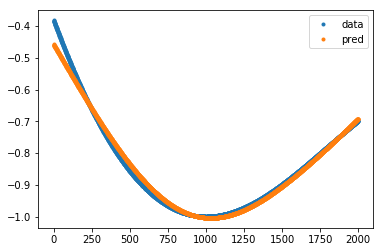

In [51]:
# Visualization
with torch.no_grad():
    
    h = 0.001;
    tt = torch.arange(-1.0, 1.0, h)  
    lentt = tt.shape[0]   
    T1 = f1(tt).view([1,lentt]).t()
    T2 = f2(tt).view([1,lentt]).t()
    T3 = f3(tt).view([1,lentt]).t()
    dataX = torch.cat((T1, T2, T3), 1)
    dataX = dataX.view(-1, dataX.shape[0], dataX.shape[1])
    T4 = f4(tt).view([1,lentt]).t()
    data = T4 
    
    # Model in evaluation state
    model.eval()      
       
    # Evalaute the model
    y_ = model(dataX)
    
    fig, ax = plt.subplots()
    ax.plot(data.numpy(),".", label="data")
    ax.plot(y_.view([lentt,1]).numpy(), ".", label="pred")
    ax.legend();